# Individual Analysis for the M&ouml;ssbauer experiment

## Full analysis template

**This template walks through the analysis starting from the raw MCA spectrum files and associated velocity transducer measurements for each sample.  If you opt to use the LabVIEW data analysis window to obtain the spectrum peak positions and widths, you should use the *Mossbauer Results-Only Analysis* template.**

Use this template to carry out the analysis tasks for the experiment.  For reference, here are links to recommended Python resources: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

We will be making use of both the [Uncertainties](https://pythonhosted.org/uncertainties/) and [LMFit](https://lmfit.github.io/lmfit-py/) packages in this notebook.

In [1]:
!pip install uncertainties
!pip install LMfit

In [2]:
import numpy as np  # import the numpy library functions.
import matplotlib.pyplot as plt # plotting functions
import uncertainties as unc # Uncertainties package.  Good for simple error propagation
import pandas as pd
%matplotlib inline

### Tasks for this analysis

For each spectrum:

1. Use the peak-to-peak amplitude from the velocity transducer and to create a calibration function (a line).  You will need the function generator period and MCS dwell time.  The function should return a velocity in mm/s given a channel number.  Negative velocities should indicate negative energy shifts, and positive velocities should indicate positive energy shifts.

2. Apply your calibration function to the spectrum data sets for all spectra and plot them.

3. Use LMFit and follow the tutorial on fitting a complicated multi-peak function to a data set to fit the absorption peaks to Lorentzians plus a parabolic (2nd order polynomial) background. (Note: you may, if you wish, fit each peak at a time rather than fit the entire spectrum with one complicated curve.)

4. From the fits, obtain the peak center (with uncertainty) and peak width for each peak in each spectrum.  Record these results in tables, one table for each sample.  

You will use the peak positions in mm/s to complete the data analysis.


### Create the calibration function(s)

Think carefully about the motion of the source: where is it at the begining of the scan?  which direction is it moving?

Think carefully about the dwell time and how long an MCS cycle takes.  (One cycle is a run through all channels.)  At which channel is the velocity zero?  Which channel would have the highest velocity forward and which would have the highest velocity in reverse.  Once you know this, you create a line that interpolates between these points.

In [3]:
# Python "dictionary" to hold the peak-to-peak velocity transducer readings, in mV
# You supply values and write the function.

Vpp = {'Enriched_Fe':47.8, "stainless":16.94, 'Nitroprusside':25.15, 'Fe2O3':75.3, 'Hematite':74.19, 'natural_Fe':50.79}

Vpp['Fe2O3']  # Should print the value for the labeled sample


75.3

#### Write the calibration function

Fill in the details below.


In [4]:
Conversion_const = unc.ufloat(.295, .002)   # Enter the conversion constant for the transducer in mm/s/(mV)

def velocity_cal(chan, Vpp, conv=Conversion_const.nominal_value, dwell=5.0e-4, period=1.00):
    '''
    Velocity calibration function.  Converts channel number 'chan' to velocity with sign
    based on the measured peak-to-peak voltage from the velocity transducer 'Vpp' (in mV),
    the transducer conversion constant 'conv' (in (mm/s)/mV), the channel dwell time
    'dwell' (in s), and the drive period 'period' (in s).
    '''

    # You fill in the details so that the return value below is correct

    velocity_period_half = 0.5 * period / dwell

    velocity_max = 0.5*conv*Vpp

    slope=-2 * velocity_max / velocity_period_half


    return(velocity_max + slope*(chan+0.5)) # slight correction to place velocity at middle of dwell time (1/2 channel)

# Test your function as follows

a_channel = 499 #+1
print("Velocity at channel {} = {:4g} mm/s".format(a_channel, velocity_cal(a_channel,Vpp=Vpp['Fe2O3'])))


Velocity at channel 499 = 0.0111067 mm/s


### Work on the first datafile

Read in the first data file and then apply the calibration to convert channel numbers to velocity.  Plot the result.

**Note:**

The calibration, if done correctly, will flip the x-axis of the data set.  Assuming you are doing this on a column in a Pandas dataframe (the default when you read a csv file with `pd.read_csv()`) then the following will reorder the channel array so that the low index is on the left of the plot and the high index is on the right:

`Fe_velocity = velocity_cal(Fe['Chan'],Vpp['Fe']).sort_values()`

where `velocity_cal()` is the calibration function, `Fe['Chan']` is the data from the **Channel** column and `Vpp['Fe']` is the peak-to-peak voltage from the velocity transducer measurement.  The method attached to the end reorders the array from lowest to highest.

***However I recommend the following.***  Just add another column to the dataframe which holds the converted channels-to-velocity.  This makes it easier to deal with slices of the array.  In other words do this:

`Fe['velocity'] = velocity_cal(Fe['Chan'],Vpp['Fe'])`

Then you can reference the original channels when you need to, but pass the velocity to the fitting routines when you need to get results in mm/s.


#### Read in the data file

The raw data files are tab separated two-column files with a one-line header that does not matter for multichannel scaling files.  You need to skip the header and name the columns to create a dataframe.

Use the **Pandas** `read_csv()` function to read the raw data file from the Norland MCA as follows:

    Fe = pd.read_csv('enriched_Fe_data.txt',header=0,names=['Chan','Counts'],sep='\t')
    
The dataframe will be named `Fe`  with columns `Fe['Chan']` ad `Fe['Counts']`.

In [5]:
# Read the data in as described.  If you end the box with the dataframe neme it will print a table of the data.

enriched_iron_data_path = '/home/toomeh/uw/winter-24/phys-431/Physics431/Lab5-Mossbauer-Spectroscopy/data/enriched_fe_57.txt'

Fe = pd.read_csv(enriched_iron_data_path, header=0, names=['Chan', 'Counts'], sep='\t')

In [6]:
np.max(Fe['Chan'])

1023

Make a plot to check that it looks right.

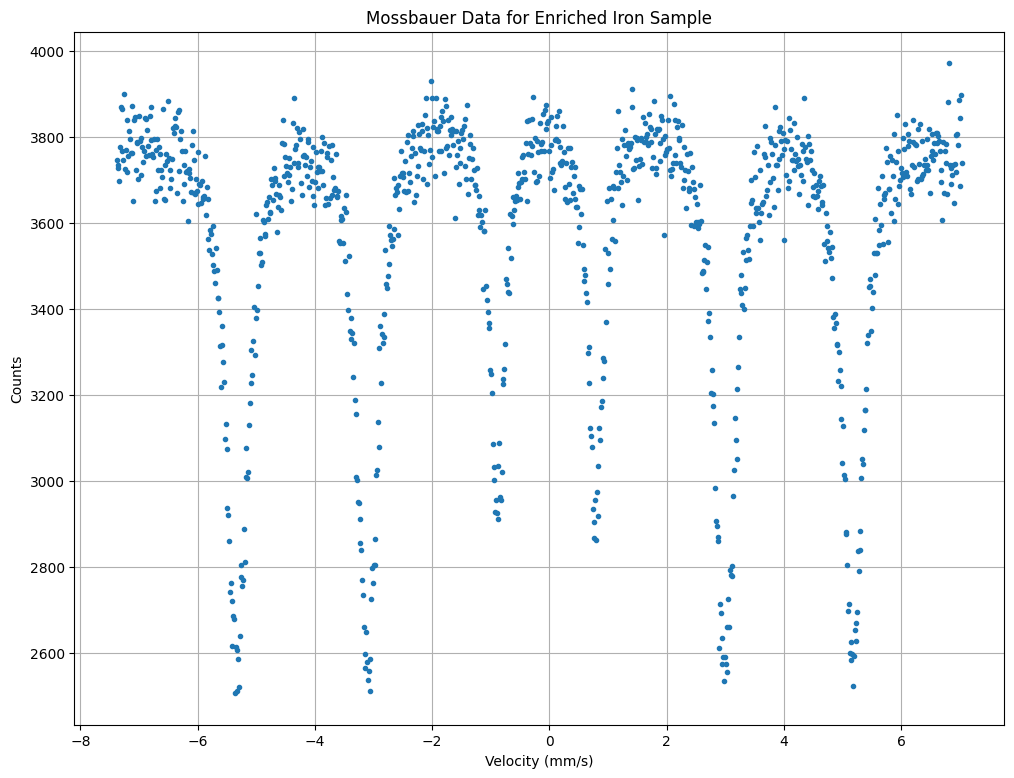

In [7]:
# Create a velocity column, as described above
Fe['velocity'] = velocity_cal(Fe['Chan'],Vpp['Enriched_Fe'])

# Sanity plot
myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.xlabel(r'Velocity (mm/s)')
plt.ylabel(r'Counts')
plt.title('Mossbauer Data for Enriched Iron Sample')
plt.plot(Fe['velocity'],Fe['Counts'],'.');

Next, plot against the column index to be able to esitmate a slice.  Take the slice and plot it to check. (these plots do not need to have axis labels, or be particularly big.)

You will also want to plot against the velocity array in order to estimate the fitting parameter start values.

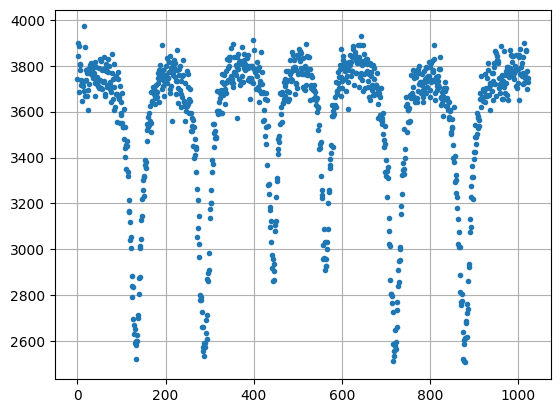

In [8]:
plt.grid()
plt.plot(Fe['Counts'],'.');

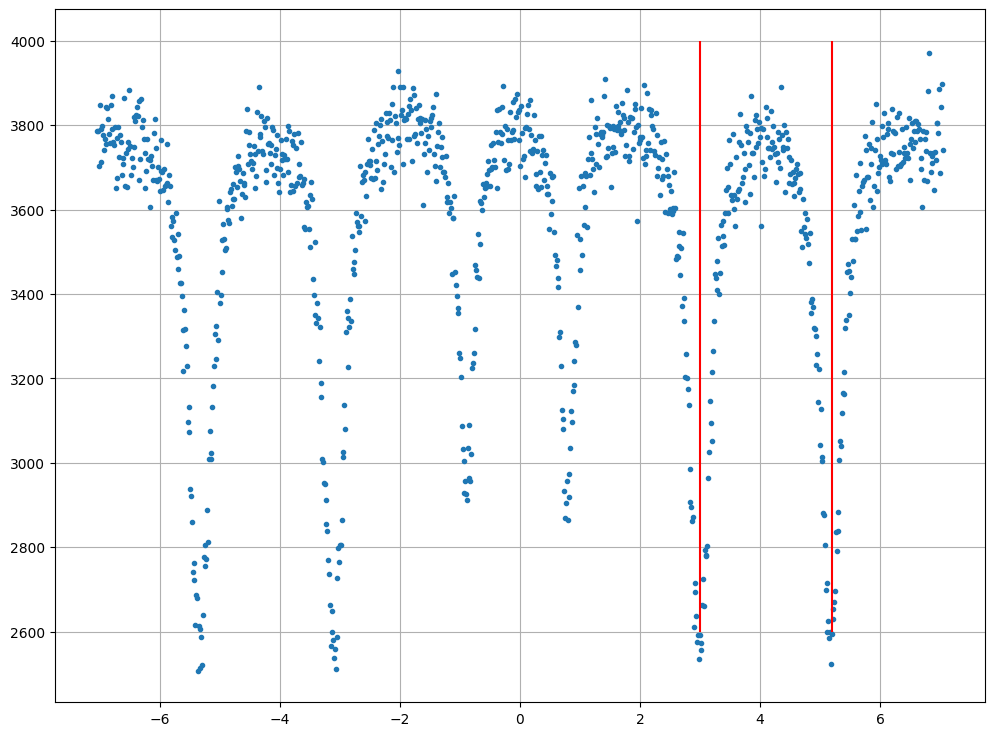

In [9]:
Index = list(range(0,1000))

myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.plot(Fe['velocity'][Index],Fe['Counts'][Index],'.')



# plt.hlines(3325, 14, 19, color='r')
plt.vlines(3, 2600, 4000, color='r')
plt.vlines(5.2, 2600, 4000, color='r')

### Fit the slice to the model

Now you should be reday to apply the procedure described in the **Composite Model Demo - Mossbauer** notebook.

Below is a reminder of the basic steps.

### Make the model

The model fit will consist of two Lorentzian peaks and a quadratic background.

The background fuction has the form
$$f(x;a,b,c) = ax^2 + bx + c\;.$$

The Lorentzian lineshape has the form
$$f(x;A,\mu,\sigma) = \frac{A}{\pi}\left[\frac{\sigma}{(x-\mu)^2 + \sigma^2}\right]\;.$$

Note that the height of the peak at the center ($x=\mu$) is equal to $\frac{A}{\pi\sigma}$ and that the full-width at half-maximum is $2\sigma$.

# Fitting the Enriched iron Model

In [10]:
# Import a gaussian peak and second order polynomial for background

from lmfit.models import QuadraticModel, LorentzianModel

# create an instance of the model
# Note use of prefixes to keep parameters separate
enriched_fe_model = QuadraticModel() + LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_') + LorentzianModel(prefix='p3_') + LorentzianModel(prefix='p4_') + LorentzianModel(prefix='p5_') + LorentzianModel(prefix='p6_')

model = enriched_fe_model

params = model.make_params()

### Set the fit parameter starting points

The first peak is shown as an example.

In [11]:
# Need to estimate height and half width at half max

outer_height = 1250.0
outer_sigma = 0.1


p1_center = -5.3
params['p1_center'].set(value=p1_center, vary=True)
params['p1_amplitude'].set(value=-outer_height*outer_sigma*np.pi, vary=True)
params['p1_sigma'].set(value=outer_sigma, vary=True)

p2_center = -3.1
params['p2_center'].set(value=p2_center, vary=True)
params['p2_amplitude'].set(value=-outer_height*outer_sigma*np.pi, vary=True)
params['p2_sigma'].set(value=outer_sigma, vary=True)



inner_height = 850
inner_sigma = 0.075

p3_center = -0.9
params['p3_center'].set(value=p3_center, vary=True)
params['p3_amplitude'].set(value=-inner_height*inner_sigma*np.pi, vary=True)
params['p3_sigma'].set(value=inner_sigma, vary=True)

p4_center = 0.8
params['p4_center'].set(value=p4_center, vary=True)
params['p4_amplitude'].set(value=-inner_height*inner_sigma*np.pi, vary=True)
params['p4_sigma'].set(value=inner_sigma, vary=True)


p5_center = 3
params['p5_center'].set(value=p5_center, vary=True)
params['p5_amplitude'].set(value=-outer_height*outer_sigma*np.pi, vary=True)
params['p5_sigma'].set(value=outer_sigma, vary=True)

p6_center = 5.2
params['p6_center'].set(value=p6_center, vary=True)
params['p6_amplitude'].set(value=-outer_height*outer_sigma*np.pi, vary=True)
params['p6_sigma'].set(value=outer_sigma, vary=True)



params['a'].set(value = 0, vary=False)
params['b'].set(value = 0, vary=False)
params['c'].set(value = 10000.0, vary=True)

params.pretty_print(columns=['value','vary'])


Name             Value     Vary
a                    0    False
b                    0    False
c                1e+04     True
p1_amplitude    -392.7     True
p1_center         -5.3     True
p1_fwhm            0.2    False
p1_height        -1250    False
p1_sigma           0.1     True
p2_amplitude    -392.7     True
p2_center         -3.1     True
p2_fwhm            0.2    False
p2_height        -1250    False
p2_sigma           0.1     True
p3_amplitude    -200.3     True
p3_center         -0.9     True
p3_fwhm           0.15    False
p3_height         -850    False
p3_sigma         0.075     True
p4_amplitude    -200.3     True
p4_center          0.8     True
p4_fwhm           0.15    False
p4_height         -850    False
p4_sigma         0.075     True
p5_amplitude    -392.7     True
p5_center            3     True
p5_fwhm            0.2    False
p5_height        -1250    False
p5_sigma           0.1     True
p6_amplitude    -392.7     True
p6_center          5.2     True
p6_fwhm 

Then fit.  The code below is an example.  Note the use of wieghts from Poisson statistics of counting and also the commands to resize the plot from the fitting routine.

[[Model]]
    ((((((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 121
    # data points      = 1000
    # variables        = 19
    chi-square         = 978.301538
    reduced chi-square = 0.99724927
    Akaike info crit   = 16.0626646
    Bayesian info crit = 109.310015
    R-squared          = 0.99999095
[[Variables]]
    a:             0 (fixed)
    b:             0 (fixed)
    c:             3836.61503 +/- 3.60144538 (0.09%) (init = 10000)
    p1_amplitude: -884.457279 +/- 13.8973248 (1.57%) (init = -392.6991)
    p1_center:    -5.33509029 +/- 0.00274615 (0.05%) (init = -5.3)
    p1_sigma:      0.22299919 +/- 0.00434858 (1.95%) (init = 0.1)
    p2_amplitude: -803.599552 +/- 12.8359658 (1.60%) (init = -392.6991)
    p2_center:   

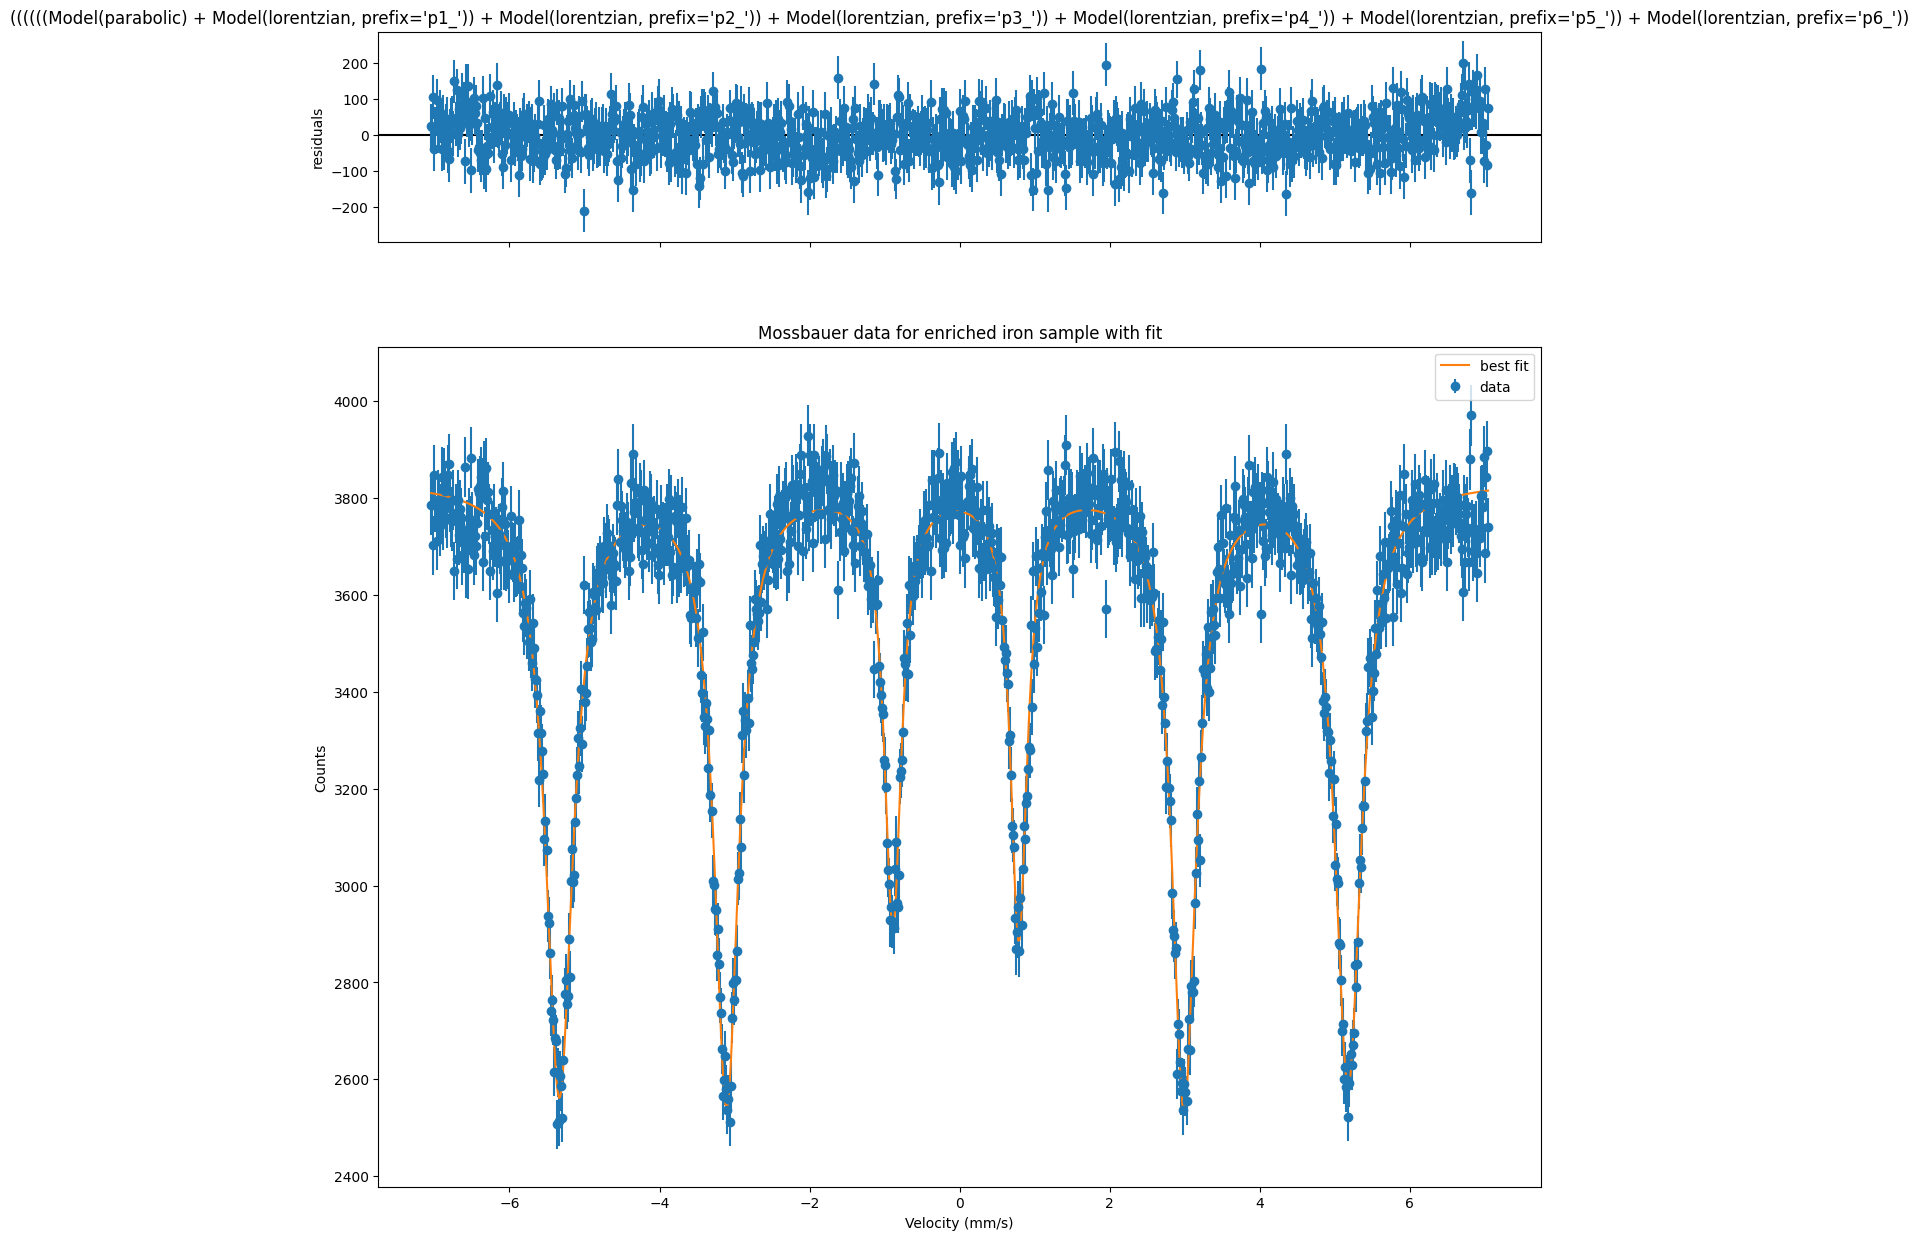

In [12]:
model_fit = model.fit(Fe['Counts'][Index], params, x=Fe['velocity'], weights=1/np.sqrt(Fe['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig)

plt.xlabel('Velocity (mm/s)')
plt.ylabel('Counts')
plt.title('Mossbauer data for enriched iron sample with fit');

#### Have you succeeded with the above?

If not,  try to fix it before mving on. If so, do the following:
1. Save your current parameters
2. Then
   * Add another peak by expanding your slice or
   * Choose a different slice and fit the peaks there
3. Save your parameters and repeat.

Your goal is to get good values of the peak locations.

(When I did it, I added peaks, two at a time, until I got a fit for the whole scan.)

### Save the peak centers

When you have obtained the best values, save the peak parameters.  I like to make a dataframe.  Here is one way to iterate over the parameters after they have been saved to extract the peak locations and uncertainties and make a table.

In [13]:
# Save the parameters from the best fit
Fe_enriched_params = model_fit.params

Fe_enriched_peaks = []
for parm in Fe_enriched_params:
    if parm.endswith('center'):
        Fe_enriched_peaks.append(unc.ufloat(Fe_enriched_params[parm].value, Fe_enriched_params[parm].stderr))
Fe_enriched_amplitudes = []
for parm in Fe_enriched_params:
    if parm.endswith('amplitude'):
        Fe_enriched_amplitudes.append(unc.ufloat(Fe_enriched_params[parm].value, Fe_enriched_params[parm].stderr))
Fe_enriched_peaks

[-5.335090287706313+/-0.002746154355974864,
 -3.1062548246222836+/-0.002563418572472692,
 -0.8892935163480955+/-0.003163264641553376,
 0.7885443488735181+/-0.003025002864459099,
 2.990818519847259+/-0.0025308444184455304,
 5.179161969671846+/-0.0027543431610521896]

In [14]:
Fe_enriched_peaks_df = pd.DataFrame()
Fe_enriched_peaks_df['Peak Number'] = [5,4,3,2,1,0]
Fe_enriched_peaks_df['Location (mm/s)'] = Fe_enriched_peaks
Fe_enriched_peaks_df['Amplitudes'] = Fe_enriched_amplitudes
Fe_enriched_peaks_df

,Peak Number,Location (mm/s),Amplitudes
0,5,-5.3351+/-0.0027,-884+/-14
1,4,-3.1063+/-0.0026,-804+/-13
2,3,-0.8893+/-0.0032,-397+/-10
3,2,0.7885+/-0.0030,-399+/-10
4,1,2.9908+/-0.0025,-800+/-13
5,0,5.1792+/-0.0028,-837+/-14


# Stainless Steel Fitting

In [15]:
stainless_steel_data_path = '/home/toomeh/uw/winter-24/phys-431/Physics431/Lab5-Mossbauer-Spectroscopy/data/stainless_steel.txt'

stainless_df = pd.read_csv(stainless_steel_data_path, header=0, names=['Chan', 'Counts'], sep='\t')

In [16]:
stainless_df['velocity'] = velocity_cal(stainless_df['Chan'],Vpp['stainless'])

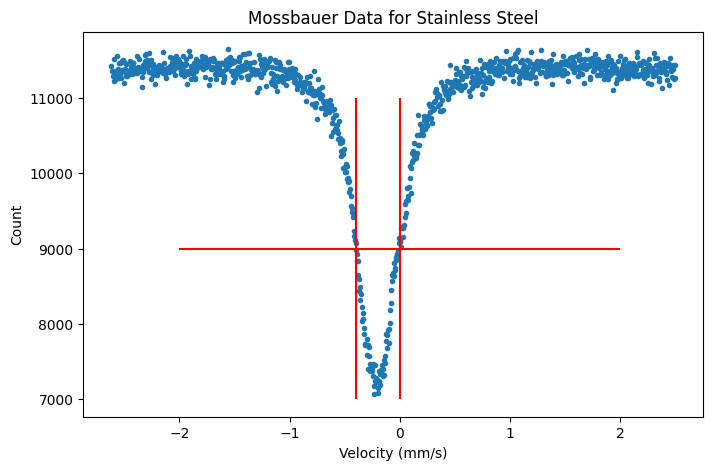

In [17]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(stainless_df['velocity'],stainless_df['Counts'],'.')
ax.set_xlabel('Velocity (mm/s)')
ax.set_ylabel('Count')
ax.set_title('Mossbauer Data for Stainless Steel')
ax.vlines(-0.4, 7000,11000, color='r')
ax.vlines(0, 7000,11000, color='r')
ax.hlines(9000, -2,2, color='r')


In [18]:
stainless_model = QuadraticModel() + LorentzianModel(prefix='p1_')

model = stainless_model

params = model.make_params()

In [19]:
# Need to estimate height and half width at half max

stainless_height = 4000
stainless_sigma = 0.2


stainless_center = -0.2
params['p1_center'].set(value=stainless_center, vary=True)
params['p1_amplitude'].set(value=-stainless_height*stainless_sigma*np.pi, vary=True)
params['p1_sigma'].set(value=stainless_sigma, vary=True)





params['a'].set(value = 0, vary=False)
params['b'].set(value = 0, vary=False)
params['c'].set(value = 10000.0, vary=True)

params.pretty_print(columns=['value','vary'])


Name             Value     Vary
a                    0    False
b                    0    False
c                1e+04     True
p1_amplitude     -2513     True
p1_center         -0.2     True
p1_fwhm            0.4    False
p1_height        -4000    False
p1_sigma           0.2     True


[[Model]]
    (Model(parabolic) + Model(lorentzian, prefix='p1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 1000
    # variables        = 4
    chi-square         = 1462.07477
    reduced chi-square = 1.46794656
    Akaike info crit   = 387.856502
    Bayesian info crit = 407.487523
    R-squared          = 0.99999851
[[Variables]]
    a:             0 (fixed)
    b:             0 (fixed)
    c:             11495.2692 +/- 5.31179600 (0.05%) (init = 10000)
    p1_amplitude: -2881.44974 +/- 18.1241634 (0.63%) (init = -2513.274)
    p1_center:    -0.20672267 +/- 9.2864e-04 (0.45%) (init = -0.2)
    p1_sigma:      0.20839094 +/- 0.00156218 (0.75%) (init = 0.2)
    p1_fwhm:       0.41678187 +/- 0.00312435 (0.75%) == '2.0000000*p1_sigma'
    p1_height:    -4401.31415 +/- 18.6071513 (0.42%) == '0.3183099*p1_amplitude/max(1e-15, p1_sigma)'


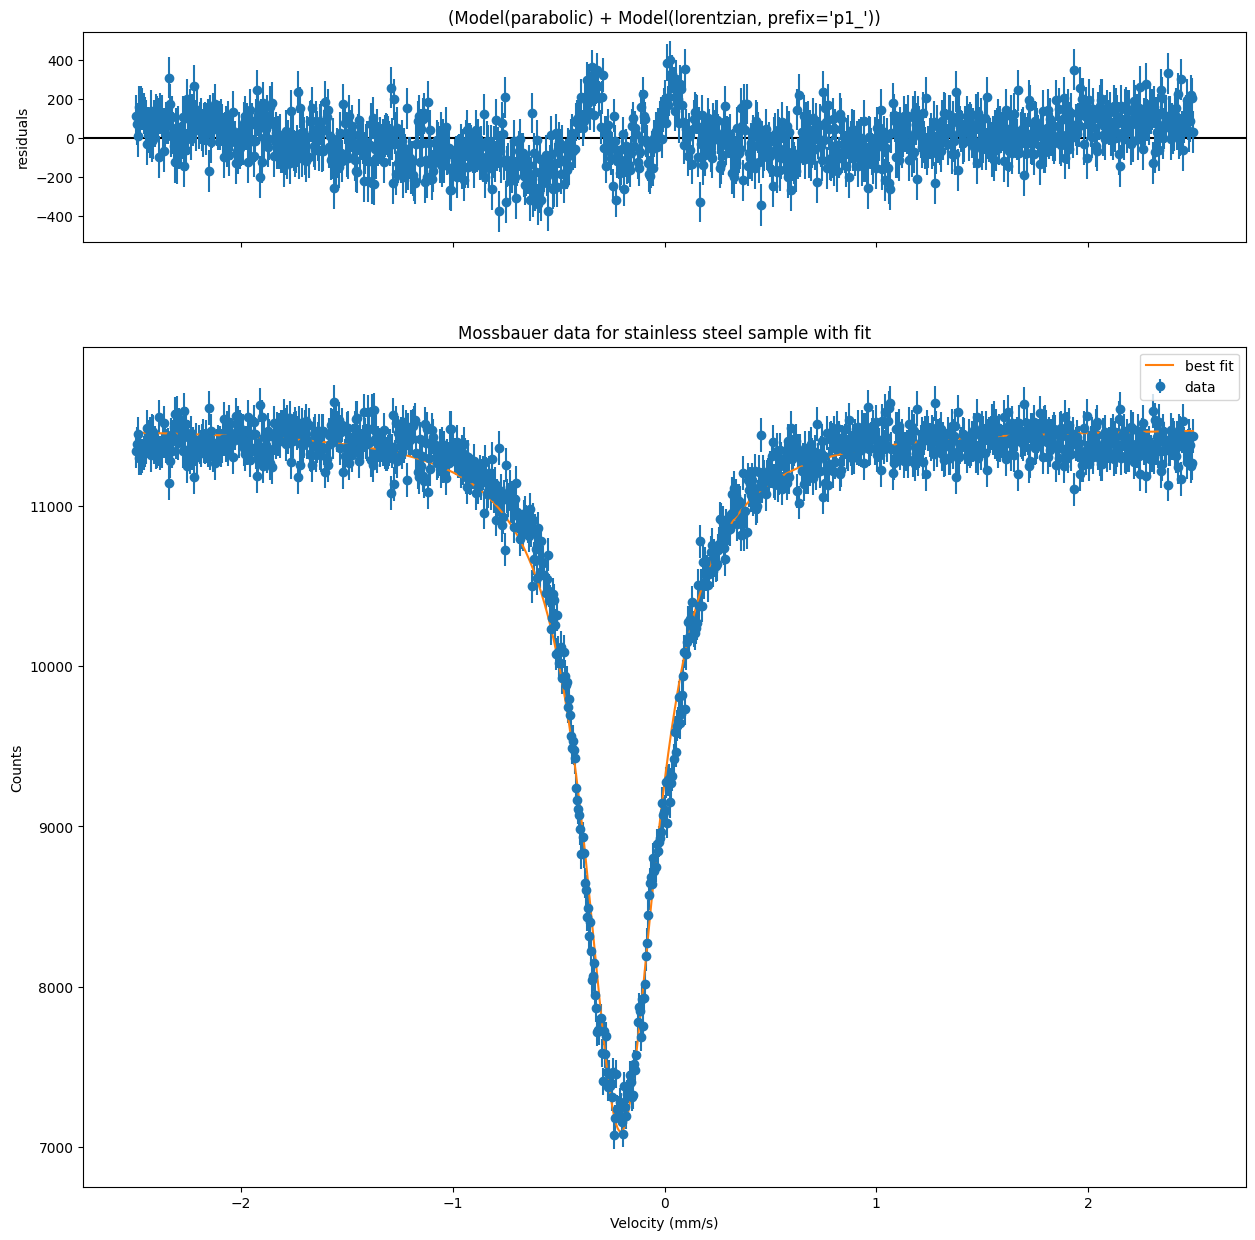

In [20]:
model_fit = model.fit(stainless_df['Counts'][Index], params, x=stainless_df['velocity'], weights=1/np.sqrt(stainless_df['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig)

plt.xlabel('Velocity (mm/s)')
plt.ylabel('Counts')
plt.title('Mossbauer data for stainless steel sample with fit');

In [21]:
stainless_params = model_fit.params

stainless_peaks = []
for parm in stainless_params:
    if parm.endswith('center'):
        stainless_peaks.append(unc.ufloat(stainless_params[parm].value, stainless_params[parm].stderr))
stainless_peaks_df = pd.DataFrame()
stainless_peaks_df['Peak Number'] = [0,]
stainless_peaks_df['Location (mm/s)'] = stainless_peaks
stainless_peaks_df

,Peak Number,Location (mm/s)
0,0,-0.2067+/-0.0009


# Hematite fitting  

In [22]:
hematite_data_path = '/home/toomeh/uw/winter-24/phys-431/Physics431/Lab5-Mossbauer-Spectroscopy/data/rust_29feb2024.txt'


hematite_df = pd.read_csv(hematite_data_path, header=0, names=['Chan', 'Counts'], sep='\t')


In [23]:
hematite_df['velocity'] = velocity_cal(hematite_df['Chan'],Vpp['Hematite'])

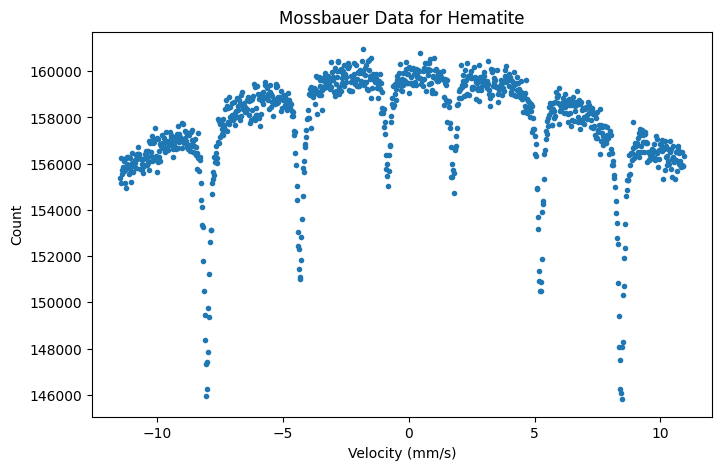

In [24]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(hematite_df['velocity'],hematite_df['Counts'],'.')
ax.set_xlabel('Velocity (mm/s)')
ax.set_ylabel('Count')
ax.set_title('Mossbauer Data for Hematite')


x = np.linspace(-11, 11, 1000)

a = -35
b = -10
c = 160000

# ax.plot(x, a*x**2 + b*x + c, color='r')

# print(a*-4.3**2 + b*-4.3 + c)

# # ax.set_xlim(-5, -4)



# ax.hlines((160000 - 9000), -6,2, color='r')
# ax.vlines(-8.05, 146000,160000, color='r')
# ax.vlines(-4.3, 146000,160000, color='r')
# ax.vlines(-0.85, 146000,160000, color='r')
# ax.vlines(1.79, 146000,160000, color='r')

# ax.vlines(5.23, 146000,160000, color='r')
# ax.vlines(8.45, 146000,160000, color='r')




In [25]:
hematite_model = QuadraticModel() + LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_') + LorentzianModel(prefix='p3_') + LorentzianModel(prefix='p4_') + LorentzianModel(prefix='p5_') + LorentzianModel(prefix='p6_')

model = hematite_model

params = model.make_params()

In [26]:
# Need to estimate height and half width at half max

height_1 = 10800


# was 7500
height_2 = 9000
height_3 = 5000

sigma = 0.025


p1_center = -8.05
params['p1_center'].set(value=p1_center, vary=True)
params['p1_amplitude'].set(value=-height_1*sigma*np.pi, vary=True)
params['p1_sigma'].set(value=sigma, vary=True)


p2_center = -4.3
params['p2_center'].set(value=p2_center, vary=True)
params['p2_amplitude'].set(value=-height_2*sigma*np.pi, vary=True)
params['p2_sigma'].set(value=sigma, vary=True)



p3_center = -0.85
params['p3_center'].set(value=p3_center, vary=True)
params['p3_amplitude'].set(value=-height_3*sigma*np.pi, vary=True)
params['p3_sigma'].set(value=sigma, vary=True)

p4_center = 1.79
params['p4_center'].set(value=p4_center, vary=True)
params['p4_amplitude'].set(value=-height_3*sigma*np.pi, vary=True)
params['p4_sigma'].set(value=sigma, vary=True)


p5_center = 5.23
params['p5_center'].set(value=p5_center, vary=True)
params['p5_amplitude'].set(value=-height_2*sigma*np.pi, vary=True)
params['p5_sigma'].set(value=sigma, vary=True)

p6_center = 8.45
params['p6_center'].set(value=p6_center, vary=True)
params['p6_amplitude'].set(value=-height_1*sigma*np.pi, vary=True)
params['p6_sigma'].set(value=sigma, vary=True)

params['a'].set(value = -500.0, vary=True)
params['b'].set(value = -10.0, vary=True)
params['c'].set(value =  160000.0, vary=True)

params.pretty_print(columns=['value','vary'])


Name             Value     Vary
a                 -500     True
b                  -10     True
c              1.6e+05     True
p1_amplitude    -848.2     True
p1_center        -8.05     True
p1_fwhm           0.05    False
p1_height     -1.08e+04    False
p1_sigma         0.025     True
p2_amplitude    -706.9     True
p2_center         -4.3     True
p2_fwhm           0.05    False
p2_height        -9000    False
p2_sigma         0.025     True
p3_amplitude    -392.7     True
p3_center        -0.85     True
p3_fwhm           0.05    False
p3_height        -5000    False
p3_sigma         0.025     True
p4_amplitude    -392.7     True
p4_center         1.79     True
p4_fwhm           0.05    False
p4_height        -5000    False
p4_sigma         0.025     True
p5_amplitude    -706.9     True
p5_center         5.23     True
p5_fwhm           0.05    False
p5_height        -9000    False
p5_sigma         0.025     True
p6_amplitude    -848.2     True
p6_center         8.45     True
p6_fwhm

[[Model]]
    ((((((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 155
    # data points      = 1000
    # variables        = 21
    chi-square         = 971.192902
    reduced chi-square = 0.99202544
    Akaike info crit   = 12.7698327
    Bayesian info crit = 115.832694
    R-squared          = 0.99999981
[[Variables]]
    a:            -33.4639810 +/- 0.40758771 (1.22%) (init = -500)
    b:            -3.87813103 +/- 2.36720321 (61.04%) (init = -10)
    c:             159980.210 +/- 24.5067441 (0.02%) (init = 160000)
    p1_amplitude: -4761.56065 +/- 84.4074801 (1.77%) (init = -848.23)
    p1_center:    -8.02542102 +/- 0.00204461 (0.03%) (init = -8.05)
    p1_sigma:      0.13210128 +/- 0.00309432 (2.34%) (init = 0.025)
    p2_ampl

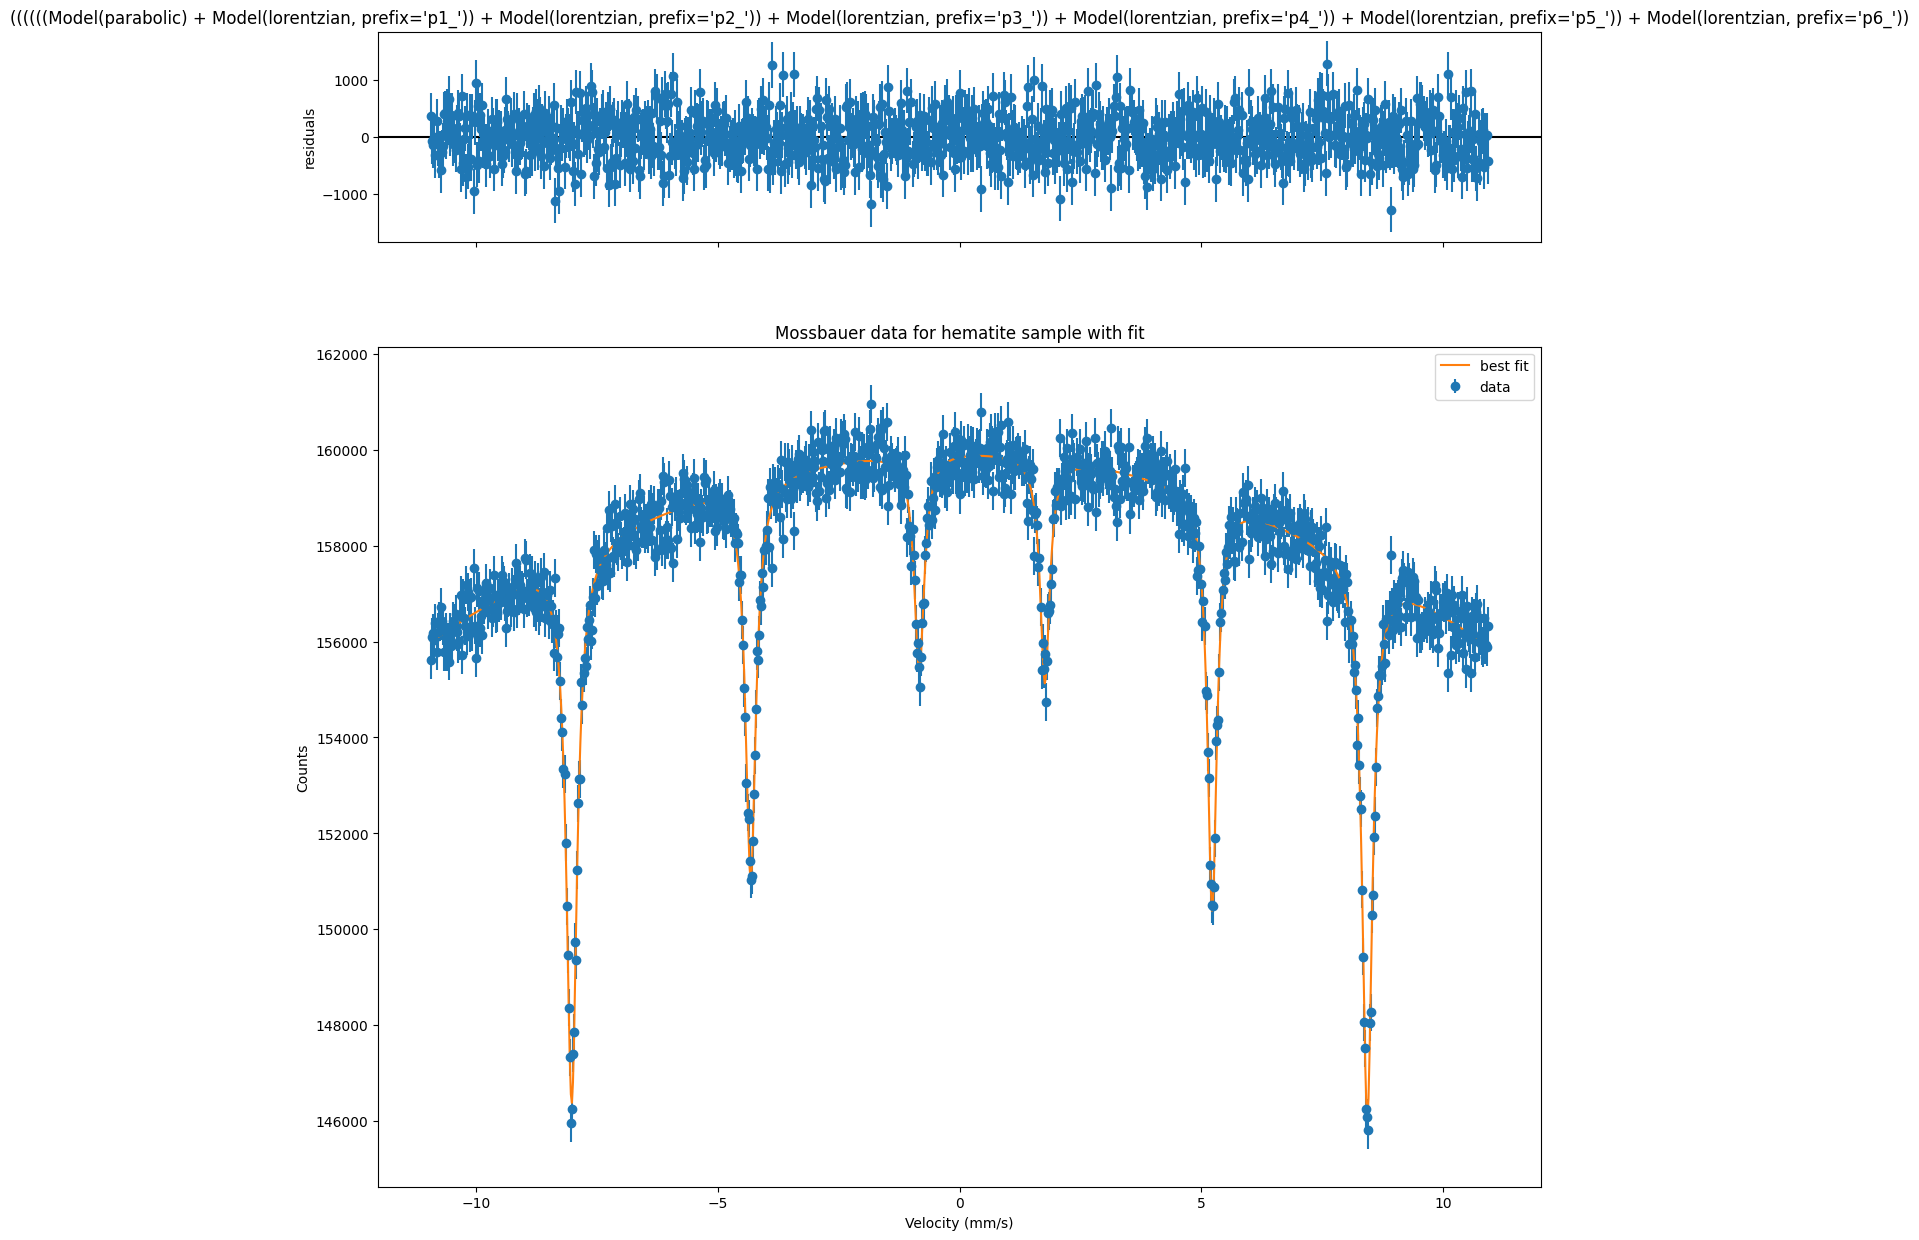

In [27]:
model_fit = model.fit(hematite_df['Counts'][Index], params, x=hematite_df['velocity'], weights=1/np.sqrt(hematite_df['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig)

plt.xlabel('Velocity (mm/s)')
plt.ylabel('Counts')
plt.title('Mossbauer data for hematite sample with fit');

In [28]:
hematite_params = model_fit.params

hematite_peaks = []
for parm in hematite_params:
    if parm.endswith('center'):
        hematite_peaks.append(unc.ufloat(hematite_params[parm].value, hematite_params[parm].stderr))

hematite_peaks_df = pd.DataFrame()
hematite_peaks_df['Peak Number'] = [5,4,3,2,1,0]
hematite_peaks_df['Location (mm/s)'] = hematite_peaks
hematite_peaks_df

,Peak Number,Location (mm/s)
0,5,-8.0254+/-0.0020
1,4,-4.3213+/-0.0028
2,3,-0.835+/-0.005
3,2,1.765+/-0.005
4,1,5.2255+/-0.0026
5,0,8.4337+/-0.0020


# Sodium Nitroprusside Fitting

In [29]:
nitroprusside_data_path = '/home/toomeh/uw/winter-24/phys-431/Physics431/Lab5-Mossbauer-Spectroscopy/data/nitroprusside_4Mar2024.txt'

nitro_df = pd.read_csv(nitroprusside_data_path, header=0, names=['Chan', 'Counts'], sep='\t')


In [30]:
nitro_df['velocity'] = velocity_cal(nitro_df['Chan'],Vpp['Nitroprusside'])

Text(0.5, 1.0, 'Mossbauer Data for Nitroprusside')

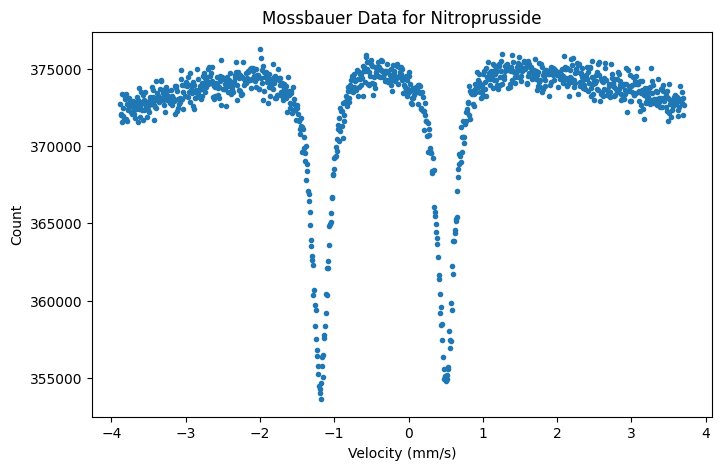

In [31]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(nitro_df['velocity'],nitro_df['Counts'],'.')
ax.set_xlabel('Velocity (mm/s)')
ax.set_ylabel('Count')
ax.set_title('Mossbauer Data for Nitroprusside')

In [32]:
nitro_model = QuadraticModel() + LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_')

model = nitro_model

params = model.make_params()

In [33]:
height = 21000
sigma = 0.14

p1_center = -1.2
params['p1_center'].set(value=p1_center, vary=True)
params['p1_amplitude'].set(value=-height*sigma*np.pi, vary=True)
params['p1_sigma'].set(value=sigma, vary=True)

p2_center = 0.5
params['p2_center'].set(value=p2_center, vary=True)
params['p2_amplitude'].set(value=-height*sigma*np.pi, vary=True)
params['p2_sigma'].set(value=sigma, vary=True)



params['a'].set(value = -200.0, vary=False)
params['b'].set(value = -10.0, vary=False)
params['c'].set(value =  375000.0, vary=True)

params.pretty_print(columns=['value','vary'])

Name             Value     Vary
a                 -200    False
b                  -10    False
c             3.75e+05     True
p1_amplitude     -9236     True
p1_center         -1.2     True
p1_fwhm           0.28    False
p1_height     -2.1e+04    False
p1_sigma          0.14     True
p2_amplitude     -9236     True
p2_center          0.5     True
p2_fwhm           0.28    False
p2_height     -2.1e+04    False
p2_sigma          0.14     True


[[Model]]
    ((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1000
    # variables        = 7
    chi-square         = 972.312017
    reduced chi-square = 0.97916618
    Akaike info crit   = -14.0785211
    Bayesian info crit = 20.2757659
    R-squared          = 0.99999994
[[Variables]]
    a:            -200 (fixed)
    b:            -10 (fixed)
    c:             375578.371 +/- 23.9023400 (0.01%) (init = 375000)
    p1_amplitude: -8331.60417 +/- 73.4441029 (0.88%) (init = -9236.282)
    p1_center:    -1.18886366 +/- 9.8593e-04 (0.08%) (init = -1.2)
    p1_sigma:      0.12686013 +/- 0.00148323 (1.17%) (init = 0.14)
    p2_amplitude: -8278.51332 +/- 73.3279169 (0.89%) (init = -9236.282)
    p2_center:     0.50108340 +/- 9.8560e-04 (0.20%) (init = 0.5)
    p2_sigma:      0.12627166 +/- 0.00148367 (1.17%) (init = 0.14)
    p1_fwhm:       0.253

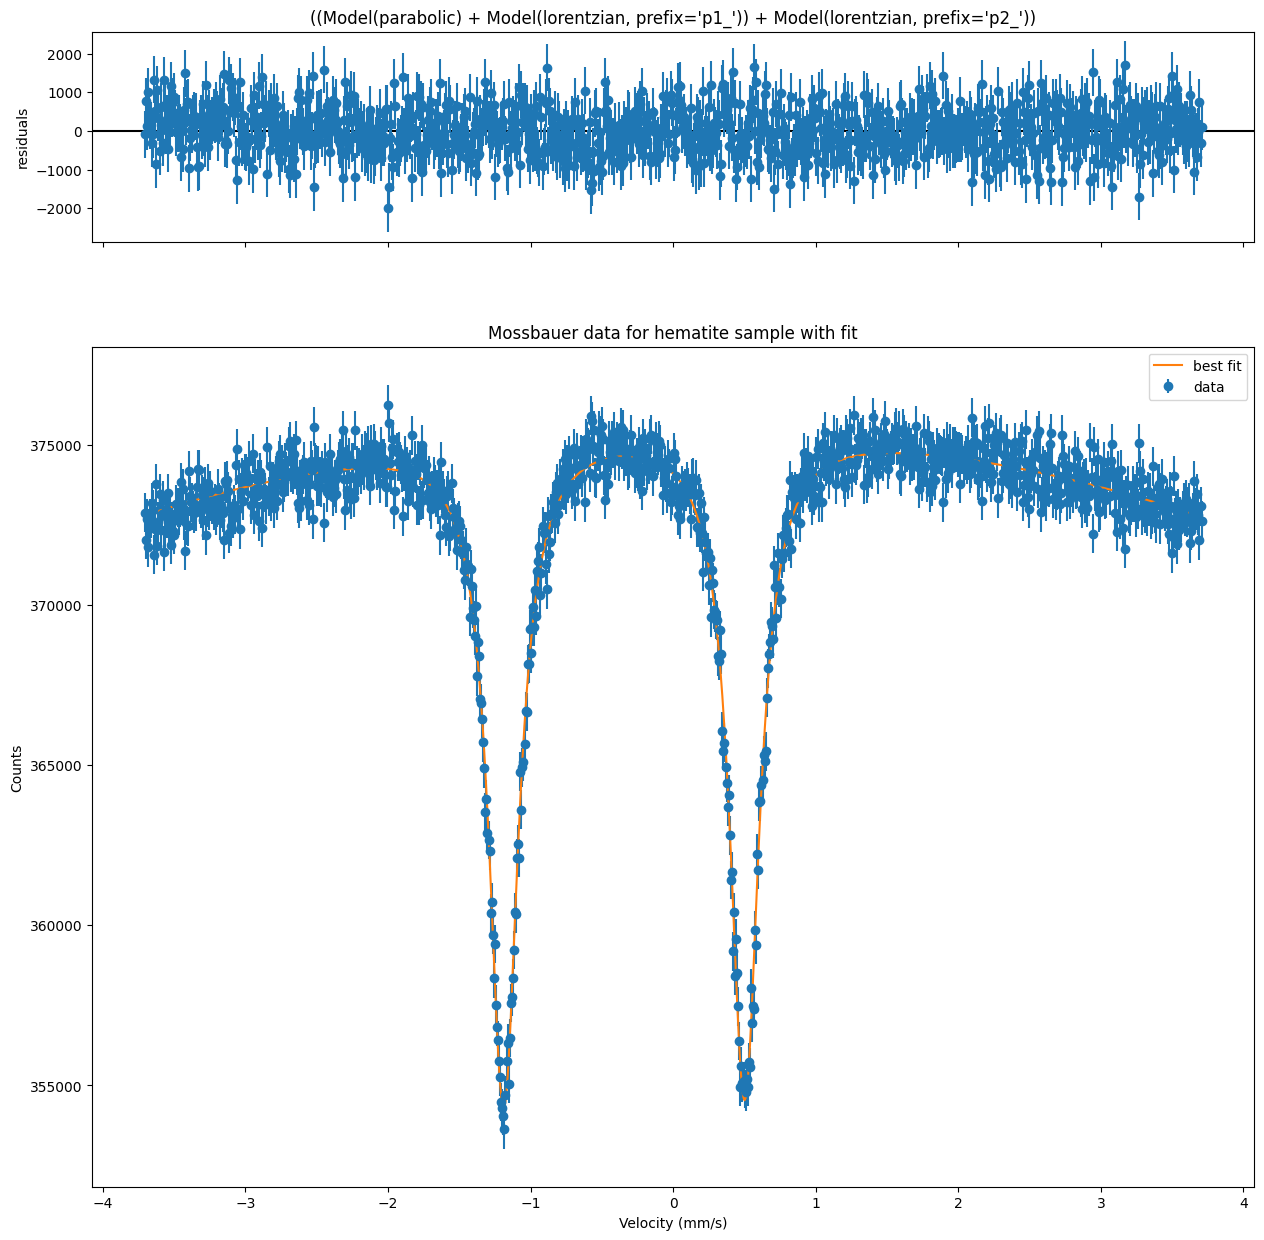

In [34]:
model_fit = model.fit(nitro_df['Counts'][Index], params, x=nitro_df['velocity'], weights=1/np.sqrt(nitro_df['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig)

plt.xlabel('Velocity (mm/s)')
plt.ylabel('Counts')
plt.title('Mossbauer data for hematite sample with fit');

In [35]:
nitro_params = model_fit.params

nitro_peaks = []
for parm in nitro_params:
    if parm.endswith('center'):
        nitro_peaks.append(unc.ufloat(nitro_params[parm].value, nitro_params[parm].stderr))

nitro_peaks_df = pd.DataFrame()
nitro_peaks_df['Peak Number'] = [1,0]
nitro_peaks_df['Location (mm/s)'] = nitro_peaks
nitro_peaks_df

,Peak Number,Location (mm/s)
0,1,-1.1889+/-0.0010
1,0,0.5011+/-0.0010


# Natural Iron

In [36]:
natural_iron_data_path = '/home/toomeh/uw/winter-24/phys-431/Physics431/Lab5-Mossbauer-Spectroscopy/data/Fe.001in_7Mar2024.txt'

natural_fe_df = pd.read_csv(natural_iron_data_path, header=0, names=['Chan', 'Counts'], sep='\t')

In [37]:
natural_fe_df['velocity'] = velocity_cal(natural_fe_df['Chan'],Vpp['natural_Fe'])

Text(0.5, 1.0, 'Mossbauer Data for Natural Iron')

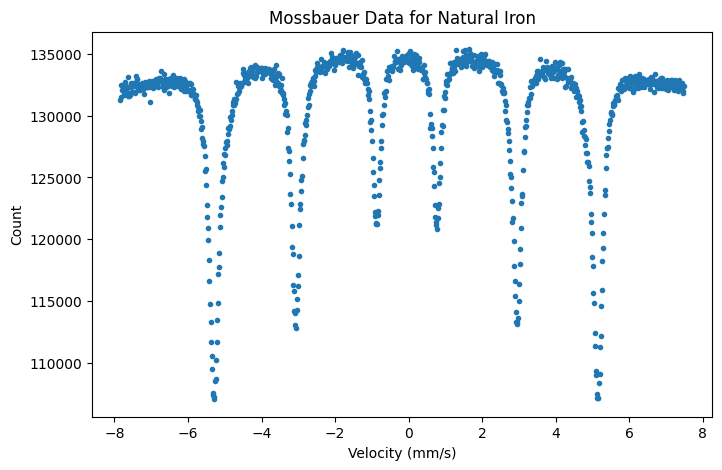

In [38]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(natural_fe_df['velocity'],natural_fe_df['Counts'],'.')
ax.set_xlabel('Velocity (mm/s)')
ax.set_ylabel('Count')
ax.set_title('Mossbauer Data for Natural Iron')


In [39]:
natural_fe_model = QuadraticModel() + LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_') + LorentzianModel(prefix='p3_') + LorentzianModel(prefix='p4_') + LorentzianModel(prefix='p5_') + LorentzianModel(prefix='p6_')

model = natural_fe_model

params = model.make_params()

In [40]:
# Need to estimate height and half width at half max

height_1 = 25679
height_2 = 21396
height_3 = 13226


sigma = 0.15


p1_center = -5.3
params['p1_center'].set(value=p1_center, vary=True)
params['p1_amplitude'].set(value=-height_1*sigma*np.pi, vary=True)
params['p1_sigma'].set(value=sigma, vary=True)

p2_center = -3.1
params['p2_center'].set(value=p2_center, vary=True)
params['p2_amplitude'].set(value=-height_2*sigma*np.pi, vary=True)
params['p2_sigma'].set(value=sigma, vary=True)


p3_center = -0.9
params['p3_center'].set(value=p3_center, vary=True)
params['p3_amplitude'].set(value=-height_3*sigma*np.pi, vary=True)
params['p3_sigma'].set(value=sigma, vary=True)

p4_center = 0.8
params['p4_center'].set(value=p4_center, vary=True)
params['p4_amplitude'].set(value=-height_3*sigma*np.pi, vary=True)
params['p4_sigma'].set(value=sigma, vary=True)


p5_center = 3
params['p5_center'].set(value=p5_center, vary=True)
params['p5_amplitude'].set(value=-height_2*sigma*np.pi, vary=True)
params['p5_sigma'].set(value=sigma, vary=True)

p6_center = 5.2
params['p6_center'].set(value=p6_center, vary=True)
params['p6_amplitude'].set(value=-height_1*sigma*np.pi, vary=True)
params['p6_sigma'].set(value=sigma, vary=True)



params['a'].set(value = -40, vary=False)
params['b'].set(value = -10, vary=False)
params['c'].set(value = 13420.0, vary=True)

params.pretty_print(columns=['value','vary'])


Name             Value     Vary
a                  -40    False
b                  -10    False
c             1.342e+04     True
p1_amplitude  -1.21e+04     True
p1_center         -5.3     True
p1_fwhm            0.3    False
p1_height     -2.568e+04    False
p1_sigma          0.15     True
p2_amplitude  -1.008e+04     True
p2_center         -3.1     True
p2_fwhm            0.3    False
p2_height     -2.14e+04    False
p2_sigma          0.15     True
p3_amplitude     -6233     True
p3_center         -0.9     True
p3_fwhm            0.3    False
p3_height     -1.323e+04    False
p3_sigma          0.15     True
p4_amplitude     -6233     True
p4_center          0.8     True
p4_fwhm            0.3    False
p4_height     -1.323e+04    False
p4_sigma          0.15     True
p5_amplitude  -1.008e+04     True
p5_center            3     True
p5_fwhm            0.3    False
p5_height     -2.14e+04    False
p5_sigma          0.15     True
p6_amplitude  -1.21e+04     True
p6_center          5.2   

[[Model]]
    ((((((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 121
    # data points      = 1000
    # variables        = 19
    chi-square         = 1667.95862
    reduced chi-square = 1.70026363
    Akaike info crit   = 549.600495
    Bayesian info crit = 642.847845
    R-squared          = 0.99999995
[[Variables]]
    a:            -40 (fixed)
    b:            -10 (fixed)
    c:             135091.486 +/- 22.9724122 (0.02%) (init = 13420)
    p1_amplitude: -13927.8682 +/- 91.2302705 (0.66%) (init = -12100.94)
    p1_center:    -5.29276547 +/- 9.4742e-04 (0.02%) (init = -5.3)
    p1_sigma:      0.16682630 +/- 0.00143316 (0.86%) (init = 0.15)
    p2_amplitude: -9390.74637 +/- 82.6298573 (0.88%) (init = -10082.63)
    p2_center:

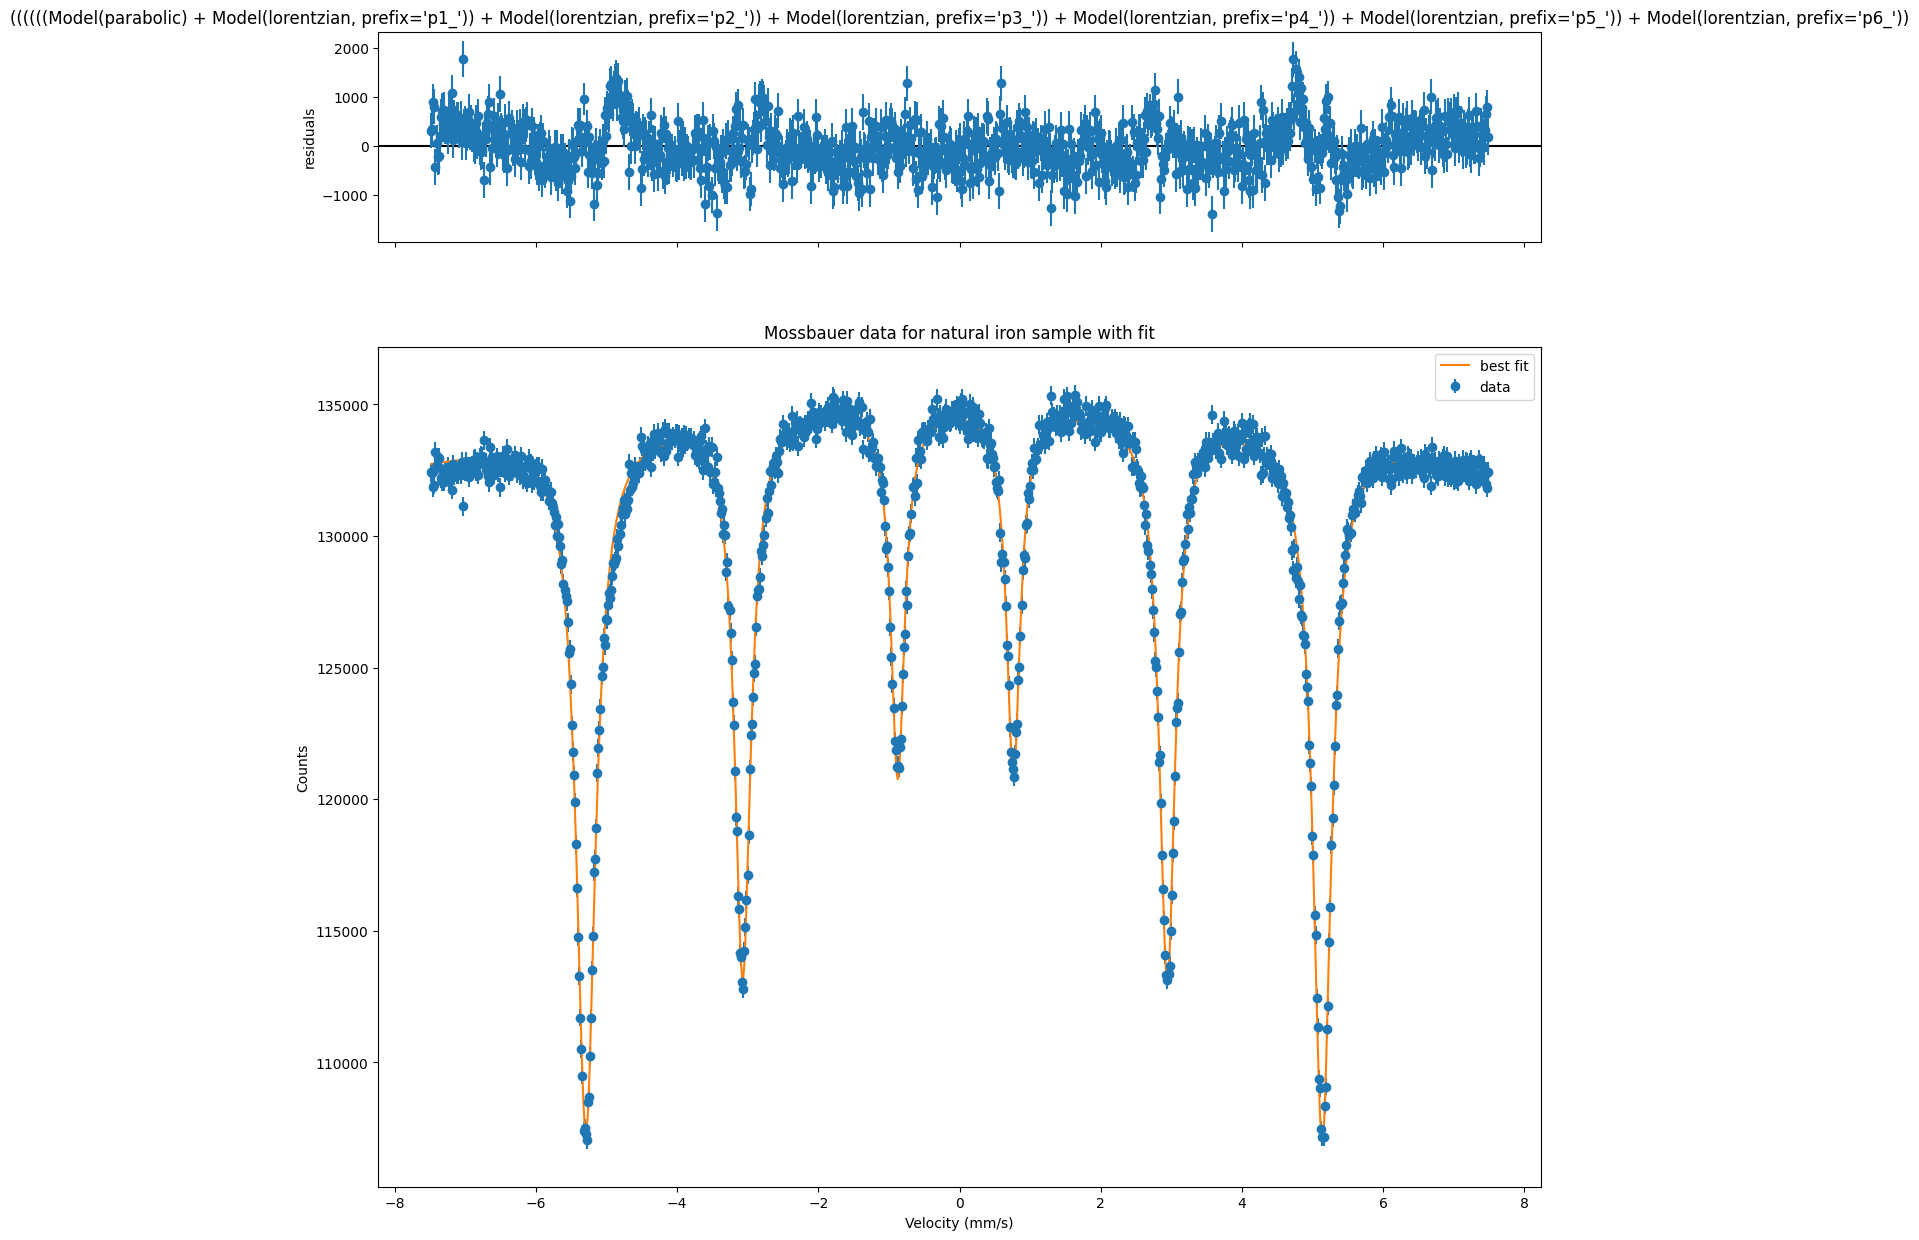

In [41]:
model_fit = model.fit(natural_fe_df['Counts'][Index], params, x=natural_fe_df['velocity'], weights=1/np.sqrt(natural_fe_df['Counts'][Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(15,15))
model_fit.plot(fig=myfig)

plt.xlabel('Velocity (mm/s)')
plt.ylabel('Counts')
plt.title('Mossbauer data for natural iron sample with fit');

In [42]:
natural_fe_params = model_fit.params

natural_fe_peaks = []
for parm in natural_fe_params:
    if parm.endswith('center'):
        natural_fe_peaks.append(unc.ufloat(natural_fe_params[parm].value, natural_fe_params[parm].stderr))
natural_fe_amplitudes = []
for parm in natural_fe_params:
    if parm.endswith('amplitude'):
        natural_fe_amplitudes.append(unc.ufloat(natural_fe_params[parm].value, natural_fe_params[parm].stderr))
print(natural_fe_peaks)
natural_fe_peaks_df = pd.DataFrame()
natural_fe_peaks_df['Peak Number'] = [5,4,3,2,1,0]
natural_fe_peaks_df['Location (mm/s)'] = natural_fe_peaks
natural_fe_peaks_df['Amplitudes'] = natural_fe_amplitudes
natural_fe_peaks_df

[-5.29276547245851+/-0.0009474152407827347, -3.071654076738652+/-0.0010978730919949085, -0.8760046254236847+/-0.0015626643274044285, 0.7621317389606096+/-0.001566043524940426, 2.9418966574059735+/-0.0010894176226148495, 5.135226896632126+/-0.0009119515191762872]


,Peak Number,Location (mm/s),Amplitudes
0,5,-5.2928+/-0.0009,(-1.393+/-0.009)e+04
1,4,-3.0717+/-0.0011,(-9.39+/-0.08)e+03
2,3,-0.8760+/-0.0016,(-5.23+/-0.08)e+03
3,2,0.7621+/-0.0016,(-5.19+/-0.08)e+03
4,1,2.9419+/-0.0011,(-9.37+/-0.08)e+03
5,0,5.1352+/-0.0009,(-1.337+/-0.009)e+04


## Calculate final results

Carry out the analysis below that is relevant to your sample types

In [43]:
def get_isomer_shift(peak_df) -> unc.ufloat:
    '''
    Takes in a peaks dataframe and returns the isomer shift with uncertainty as an unc ufloat object
    '''

    location_list = peak_df['Location (mm/s)'].tolist()

    nominal_values = [x.nominal_value for x in location_list]
    uncertainties = [x.std_dev for x in location_list]

    avg_nominal = sum(nominal_values) / len(nominal_values)
    avg_uncertainty = sum(uncertainties) / len(uncertainties)

    return unc.ufloat(avg_nominal, avg_uncertainty)

### Enriched iron and Natural iron

1. Start with isomer shift $\delta$. This is just the average of all peak locations. The number would be relative to the source Co-57/Rh

2. Next calculate the magnetic field $B$ and excited-state moment $\mu_e$ from the enriched-foil data.  

For the field, we first need the transitions that start from different ground states and end at the same excited states.  There are two pairs of these, one pair ends at -1/2: peaks 2 & 4, and the other ends at +1/2, peaks 1 and 3. The differences between these will give $\mu_gB$.  From this get $B$ with $\mu_g = +0.09062\mu_n$ where $\mu_n = 3.1525\times10^{-8}$ eV/T

You will need to convert to energy with Doppler formula
$$\frac{\Delta E}{E} = \frac{v}{c}$$
where $E = 14.412497$ keV.

To get the excited state moment, you will need the excited state splitting. These pairs that start at the same ground state but end at different excited states: peaks 0-1, 1-2, 3-4, and 4-5.

3. From this calculate the excited state moment $\mu_e$, and compare to $-0.1549\mu_n$.

4. Repeat the above for any other natural iron samples you may have. (Don't forget to apply the correct calibration constant for each one.)

1. Isomer shift

In [44]:
enriched_fe_isomer_shift = get_isomer_shift(Fe_enriched_peaks_df)
print(f'The isomer shift for enriched iron is: {enriched_fe_isomer_shift} mm/s')

The isomer shift for enriched iron is: -0.0620+/-0.0028 mm/s


In [45]:
natural_fe_isomer_shift = get_isomer_shift(natural_fe_peaks_df)
print(f'The isomer shift for natural iron is: {natural_fe_isomer_shift} mm/s')
print(f'The difference between the natural iron and enriched iron isomer shift is: {natural_fe_isomer_shift - enriched_fe_isomer_shift} mm/s')

The isomer shift for natural iron is: -0.0669+/-0.0012 mm/s
The difference between the natural iron and enriched iron isomer shift is: -0.0048+/-0.0030 mm/s


In [46]:
Fe_enriched_peaks_df['location minus isomer (mm/s)'] = Fe_enriched_peaks_df['Location (mm/s)'] - enriched_fe_isomer_shift

In [47]:
natural_fe_peaks_df['location minus isomer (mm/s)'] = natural_fe_peaks_df['Location (mm/s)'] - natural_fe_isomer_shift

Magnetic field calculation

In [48]:
# E in keV
E = 14.412497
c = 3e11

Fe_enriched_peaks_df['Energy shift (keV)'] = Fe_enriched_peaks_df['Location (mm/s)'] * E / c


# convert to keV /T

mu_n = 3.1525e-11
mu_g = 0.09062 * mu_n

In [49]:
# Natural Fe
natural_fe_peaks_df['Energy shift (keV)'] = natural_fe_peaks_df['Location (mm/s)'] * E / c


E1 and E3

In [50]:

# E1 - E3
enriched_fe_e1_e3 = Fe_enriched_peaks_df['Energy shift (keV)'].loc[4] - Fe_enriched_peaks_df['Energy shift (keV)'].loc[2]

enriched_fe_b_field_1 = 0.5 * enriched_fe_e1_e3/ mu_g

print(f'The value of the magnetic field for the enriched iron is: {enriched_fe_b_field_1} Tesla')

The value of the magnetic field for the enriched iron is: 32.625+/-0.034 Tesla


In [51]:
# Natural Fe

natural_fe_e1_e3 = natural_fe_peaks_df['Energy shift (keV)'].loc[4] - natural_fe_peaks_df['Energy shift (keV)'].loc[2]

natural_fe_b_field_1 = 0.5 * natural_fe_e1_e3/ mu_g

print(f'The value of the magnetic field for the natural iron is: {natural_fe_b_field_1} Tesla')

The value of the magnetic field for the natural iron is: 32.102+/-0.016 Tesla


E2 and E4

In [52]:

# E2 - E4
enriched_fe_e2_e4 = Fe_enriched_peaks_df['Energy shift (keV)'].loc[3] - Fe_enriched_peaks_df['Energy shift (keV)'].loc[1]


enriched_fe_b_field_2 = 0.5 * enriched_fe_e2_e4/ mu_g


print(f'The value of the magnetic field for the enriched iron is: {enriched_fe_b_field_2} Tesla')

The value of the magnetic field for the enriched iron is: 32.749+/-0.033 Tesla


In [53]:
enriched_fe_b_field_final = (enriched_fe_b_field_1 + enriched_fe_b_field_2) / 2

In [54]:
# Natural Fe

natural_fe_e2_e4 = natural_fe_peaks_df['Energy shift (keV)'].loc[3] - natural_fe_peaks_df['Energy shift (keV)'].loc[1]


natural_fe_b_field_2 = 0.5 * natural_fe_e2_e4/ mu_g


print(f'The value of the magnetic field for the enriched iron is: {natural_fe_b_field_2} Tesla')

The value of the magnetic field for the enriched iron is: 32.236+/-0.016 Tesla


In [55]:
natural_fe_b_field_final = (natural_fe_b_field_1 + natural_fe_b_field_2) / 2
print(f'The difference between the natural Fe B field and the enriched Fe B field is {natural_fe_b_field_final - enriched_fe_b_field_final} Tesla')

The difference between the natural Fe B field and the enriched Fe B field is -0.518+/-0.026 Tesla


Excited state calculation


E0 and E1

In [56]:
# E0 - E1

enriched_fe_e2_e4 = Fe_enriched_peaks_df['Energy shift (keV)'].loc[5] - Fe_enriched_peaks_df['Energy shift (keV)'].loc[4]
mu_e = -3/2 * enriched_fe_e2_e4 / enriched_fe_b_field_final


mu_e_theory = -0.1549 * mu_n


print(f'The theoretical value of mu_e is {mu_e_theory:.5} eV/T')
print(f'The experimental value of mu_e is {mu_e:.5} eV/T')


The theoretical value of mu_e is -4.8832e-12 eV/T
The experimental value of mu_e is (-4.8245+/-0.0099)e-12 eV/T


In [57]:
# Natural Fe

natural_fe_e2_e4 = natural_fe_peaks_df['Energy shift (keV)'].loc[5] - natural_fe_peaks_df['Energy shift (keV)'].loc[4]

natural_fe_mu_e = -3/2 * natural_fe_e2_e4 / enriched_fe_b_field_final


mu_e_theory = -0.1549 * mu_n


print(f'The theoretical value of mu_e is {mu_e_theory:.5} eV/T')
print(f'The experimental value of mu_e for natural iron is {natural_fe_mu_e:.5} eV/T')
print(f'The difference between the value of mu_e for natural iron and enriched iron is {natural_fe_mu_e - mu_e :.5} eV/T')


The theoretical value of mu_e is -4.8832e-12 eV/T
The experimental value of mu_e for natural iron is (-4.8355+/-0.0047)e-12 eV/T
The difference between the value of mu_e for natural iron and enriched iron is (-1.0994+/-0.8819)e-14 eV/T


Amplitude Comparison

In [58]:
Fe_amplitude_diff_df = pd.DataFrame()
Fe_amplitude_diff_df['Amplitude diff'] = natural_fe_peaks_df['Amplitudes'] - Fe_enriched_peaks_df['Amplitudes']

amplitude_list = Fe_amplitude_diff_df['Amplitude diff'].tolist()

nominal_values = [x.nominal_value for x in amplitude_list]
uncertainties = [x.std_dev for x in amplitude_list]
print(Fe_amplitude_diff_df)
print(f'The average value of amplitude difference between the natural iron and the enriched iron peaks is {unc.ufloat(sum(nominal_values) / len(nominal_values), sum(uncertainties) / len(uncertainties))}')

         Amplitude diff
0  (-1.304+/-0.009)e+04
1    (-8.59+/-0.08)e+03
2    (-4.83+/-0.08)e+03
3    (-4.79+/-0.08)e+03
4    (-8.57+/-0.08)e+03
5  (-1.253+/-0.009)e+04
The average value of amplitude difference between the natural iron and the enriched iron peaks is (-8.73+/-0.08)e+03


### Sodium nitroprusside

Need isomer shift relative to Fe foil and quadrupole split, both in mm/s units.

Compare results to literature values of $-0.257$ mm/s for the isomer shift, relative to Fe and $1.7048$ mm/s for the quadrupole splitting.  

In [59]:

nitro_isomer = get_isomer_shift(nitro_peaks_df)
nitro_isomer_literature = -0.257
percent_error = np.abs(nitro_isomer.nominal_value - nitro_isomer_literature) / np.abs(nitro_isomer_literature)


print(f'The isomer shift for sodium nitroprusside is: {nitro_isomer} mm/s')
print(f'This value differs from the literature value of {nitro_isomer_literature} mm/s by {percent_error * 100.0:.2f}%')

The isomer shift for sodium nitroprusside is: -0.3439+/-0.0010 mm/s
This value differs from the literature value of -0.257 mm/s by 33.81%


### Stainless steel

There is only one peak for the stainless-steel sample, so the only task is to obtain the isomer shift $\delta$. From the referece work by Greenwood and Gibb, typical shifts relative to natural iron are $-0.09$ mm/s with a range between $-0.077$ to $-0.096$ mm/s depending on the alloy type.

Also find the width of the peak and study the following:
* How does the width of the single peak compare to the width of one peak for enriched iron?  Is there evidence of a weak internal field?
* How well does the Lorentzian peak shape fit for stainless?  If it does not fit as well, what could be the reason(s)?

In [60]:
stainless_isomer = get_isomer_shift(stainless_peaks_df)
print(f'The isomer shift for stainless steel is: {stainless_isomer} mm/s ')
print(f'The difference between the stainless steel and enriched iron isomer shift is: {stainless_isomer - enriched_fe_isomer_shift} mm/s')

The isomer shift for stainless steel is: -0.2067+/-0.0009 mm/s 
The difference between the stainless steel and enriched iron isomer shift is: -0.1447+/-0.0029 mm/s


In [61]:
exp_difference = stainless_isomer - enriched_fe_isomer_shift
stainless_isomer_literature_low = -0.077
stainless_isomer_literature_high = -0.096
stainless_low_percent_error = np.abs(exp_difference - stainless_isomer_literature_low)* 100 / np.abs(stainless_isomer_literature_low)
stainless_high_percent_error = np.abs(exp_difference - stainless_isomer_literature_high)* 100 / np.abs(stainless_isomer_literature_high)


print(f'The literature values for the stainless steel isomer shift range from {stainless_isomer_literature_low} mm/s to {stainless_isomer_literature_high} mm/s')
print(f'The percent error of our values range from: {stainless_low_percent_error:.2f}% to {stainless_high_percent_error:.2f}%')

The literature values for the stainless steel isomer shift range from -0.077 mm/s to -0.096 mm/s
The percent error of our values range from: 87.93+/-3.83% to 50.73+/-3.07%


Width of the peak

In [62]:
fe_enriched_sigma_values = []
fe_enriched_sigma_errors = []

for param in Fe_enriched_params:
    if param.endswith('sigma'):
        fe_enriched_sigma_values.append(Fe_enriched_params[param].value )
        fe_enriched_sigma_errors.append(Fe_enriched_params[param].stderr)




print(fe_enriched_sigma_values)


fe_enriched_sigma_average = unc.ufloat(np.mean(fe_enriched_sigma_values), np.mean(fe_enriched_sigma_errors))


[0.22299918723082857, 0.20037940241373953, 0.14042611685128237, 0.13683304218176406, 0.19824227992378574, 0.21486997097091254]


In [63]:
stainless_sigma = unc.ufloat(stainless_params['p1_sigma'].value, stainless_params['p1_sigma'].stderr)

# stainless_params['p1_sigma']

print(f'The width of the peak for stainless steel at half maximum is {2*stainless_sigma} mm/s')
print(f'The average width of the peak for enriched iron at half maximum is {2*fe_enriched_sigma_average} mm/s')
print(f'These two values differ by {2*np.abs(stainless_sigma-fe_enriched_sigma_average)}')


The width of the peak for stainless steel at half maximum is 0.4168+/-0.0031 mm/s
The average width of the peak for enriched iron at half maximum is 0.371+/-0.009 mm/s
These two values differ by 0.046+/-0.009


In [64]:

timescale = 1.4e-7
hbar = 6.582e-16


delta_E = hbar/timescale

print(delta_E)
print(2*stainless_sigma*E/c*1000)
print(delta_E/(1000*(mu_g-mu_e)),"B")

4.7014285714285715e-09
(2.002+/-0.015)e-08
0.6121+/-0.0008 B


### Hematite (Rust)

Analysis proceeds in same manner as for enriched Fe foil. Find $\delta$, $B$, $\mu_e$.

#### Then find quadrupole splitting

From Figure 2 in Kistner & Sunyar (PRL Vol. 4, p.412, 1960) peaks 0-1 are closer together than 1-2 by $2\varepsilon$ and peaks 4-5 are farther apart than peaks 3-4.  To find $\varepsilon$ we note that (4-5)-(0-1) should be equal to $4\varepsilon$.

Compare to following results in Kistner & Sunyar:
* G.S Splitting = $6.11\pm0.05$ mm/s
* E.S. splitting = $3.45\pm0.03$ mm/s
* Isomer shift relative to Fe = $0.47\pm0.03$ mm/s
* Quadrupole splitting $\varepsilon = 0.12\pm0.03$ mm/s

## Hematite Isomer Shift

In [65]:
hematite_isomer_shift = get_isomer_shift(hematite_peaks_df)

literature_hematite_isomer = unc.ufloat(0.47, 0.03)

print(f'The isomer shift for hematite is: {hematite_isomer_shift} mm/s')
print(f'The difference between the hematite and enriched iron is: {hematite_isomer_shift - enriched_fe_isomer_shift:.4f} mm/s')
print(f'The literature value for the isomer shift of hematite is: {literature_hematite_isomer} mm/s')


The isomer shift for hematite is: 0.3737+/-0.0032 mm/s
The difference between the hematite and enriched iron is: 0.4358+/-0.0043 mm/s
The literature value for the isomer shift of hematite is: 0.470+/-0.030 mm/s


## Hematite B

In [66]:
hematite_peaks_df['Energy shift (keV)'] = hematite_peaks_df['Location (mm/s)'] * E / c

In [67]:
# E1 - E3
hematite_e1_e3 = hematite_peaks_df['Energy shift (keV)'].loc[4] - hematite_peaks_df['Energy shift (keV)'].loc[2]

hematite_b_field_1 = 0.5 * hematite_e1_e3/ mu_g

print(f'The value of the magnetic field for the hematite is: {hematite_b_field_1} Tesla')

The value of the magnetic field for the hematite is: 50.95+/-0.05 Tesla


In [68]:
# E2 - E4
hematite_e2_e4 = hematite_peaks_df['Energy shift (keV)'].loc[3] - hematite_peaks_df['Energy shift (keV)'].loc[1]

hematite_b_field_2 = 0.5 * hematite_e2_e4/ mu_g

print(f'The value of the magnetic field for the hematite is: {hematite_b_field_2} Tesla')

The value of the magnetic field for the hematite is: 51.17+/-0.05 Tesla


In [69]:
hematite_b_field_final = (hematite_b_field_1 + hematite_b_field_2) / 2

print(f'The average determined value of the magnetic field for hematite is: {hematite_b_field_final} Tesla')

The average determined value of the magnetic field for hematite is: 51.063+/-0.034 Tesla


## Mu_e hematite

In [70]:
# E0 - E1

hematite_e2_e4 = hematite_peaks_df['Energy shift (keV)'].loc[5] - hematite_peaks_df['Energy shift (keV)'].loc[4]

mu_e = -3/2 * hematite_e2_e4 / hematite_b_field_final


mu_e_theory = -0.1549 * mu_n


print(f'The theoretical value of mu_e is {mu_e_theory:.5} eV/T')

print(f'The experimental value of mu_e is {mu_e:.5} eV/T')


The theoretical value of mu_e is -4.8832e-12 eV/T
The experimental value of mu_e is (-4.5276+/-0.0061)e-12 eV/T


## Hematite quadropole splitting

In [71]:
hematite_peaks_df

,Peak Number,Location (mm/s),Energy shift (keV)
0,5,-8.0254+/-0.0020,(-3.8555+/-0.0010)e-10
1,4,-4.3213+/-0.0028,(-2.0760+/-0.0014)e-10
2,3,-0.835+/-0.005,(-4.009+/-0.025)e-11
3,2,1.765+/-0.005,(8.477+/-0.023)e-11
4,1,5.2255+/-0.0026,(2.5104+/-0.0012)e-10
5,0,8.4337+/-0.0020,(4.0517+/-0.0010)e-10


In [72]:
# (4-5) - (0-1) = 4 epsilon

hematite_4_5 = hematite_peaks_df['Location (mm/s)'].loc[1] - hematite_peaks_df['Location (mm/s)'].loc[0]
hematite_0_1 = hematite_peaks_df['Location (mm/s)'].loc[5] - hematite_peaks_df['Location (mm/s)'].loc[4]

hematite_epsilon = (hematite_4_5 - hematite_0_1) / 4
hematite_epsilon_literature = unc.ufloat(0.12, 0.03)


print(f'The value of the quadropole splitting for hematite is: {hematite_epsilon} mm/s')
print(f'The literature value for the quadropole splitting of hematite is: {hematite_epsilon_literature} mm/s')


The value of the quadropole splitting for hematite is: 0.1240+/-0.0012 mm/s
The literature value for the quadropole splitting of hematite is: 0.120+/-0.030 mm/s
